In [4]:
import os
import glob
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
from rasterio.warp import transform_bounds
import contextily as ctx
from matplotlib.patches import Rectangle
import numpy as np

In [1]:
import whitebox

wbt = whitebox.WhiteboxTools()


Decompressing WhiteboxTools_darwin_m_series.zip ...
WhiteboxTools package directory: /opt/miniconda3/envs/geospatial-processing/lib/python3.13/site-packages/whitebox


In [16]:
def get_raster_footprint(img_path):
    """
    Extract the geographic footprint of a raster file.
    Returns a Polygon geometry in WGS84 (EPSG:4326).
    """
    with rasterio.open(img_path) as src:
        # Get bounds in the original CRS
        bounds = src.bounds
        
        # Transform bounds to WGS84 if not already
        if src.crs != 'EPSG:4326':
            bounds = transform_bounds(src.crs, 'EPSG:4326', *bounds)
        
        # Create polygon from bounds (minx, miny, maxx, maxy)
        footprint = Polygon([
            (bounds[0], bounds[1]),  # bottom-left
            (bounds[2], bounds[1]),  # bottom-right
            (bounds[2], bounds[3]),  # top-right
            (bounds[0], bounds[3]),  # top-left
            (bounds[0], bounds[1])   # close polygon
        ])
        
        return footprint, os.path.basename(img_path)

def plot_raster_footprints(img_directory, output_path=None, add_basemap=True):
    """
    Plot footprints of all IMG files in a directory on a single map.
    
    Parameters:
    - img_directory: Path to directory containing .img files
    - output_path: Optional path to save the plot
    - add_basemap: Whether to add a basemap for context
    """
    
    # Find all .img files
    img_files = glob.glob(os.path.join(tif_directory, "*.img"))
    img_files.extend(glob.glob(os.path.join(tif_directory, "*.IMG")))
    
    if not img_files:
        print(f"No .img files found in {tif_directory}")
        return
    
    print(f"Found {len(img_files)} raster files")
    
    # Extract footprints
    footprints = []
    names = []
    
    for img_file in img_files:
        try:
            footprint, name = get_raster_footprint(img_file)
            footprints.append(footprint)
            names.append(name)
            #print(f"Processed: {name}")
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
    
    if not footprints:
        print("No valid footprints extracted")
        return
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame({
        'filename': names,
        'geometry': footprints
    }, crs='EPSG:4326')
    
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    
    # Plot footprints with different colors
    colors = plt.cm.Set3(np.linspace(0, 1, len(footprints)))
    
    for i, (idx, row) in enumerate(gdf.iterrows()):
        gdf.iloc[[i]].boundary.plot(
            ax=ax, 
            color=colors[i], 
            linewidth=2, 
            label=row['filename']
        )
        # Add semi-transparent fill
        gdf.iloc[[i]].plot(
            ax=ax, 
            color=colors[i], 
            alpha=0.3
        )
    
    # Add basemap if requested
    if add_basemap:
        try:
            # Convert to Web Mercator for basemap
            gdf_web_mercator = gdf.to_crs(epsg=3857)
            ctx.add_basemap(ax, crs=gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)
        except Exception as e:
            print(f"Could not add basemap: {e}")
    
    # Customize the plot
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Raster Footprints ({len(footprints)} files)', fontsize=14, fontweight='bold')
    
    # Add legend (limit to first 10 items if too many)
    if len(names) <= 10:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                 labels=names[:10] + [f'... and {len(names)-10} more'])
    
    # Set equal aspect ratio and tight layout
    ax.set_aspect('equal')
    plt.tight_layout()
    
    # Save if output path provided
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {output_path}")
    
    plt.show()
    
    return gdf


Found 433 raster files
Plot saved to: raster_footprints.png


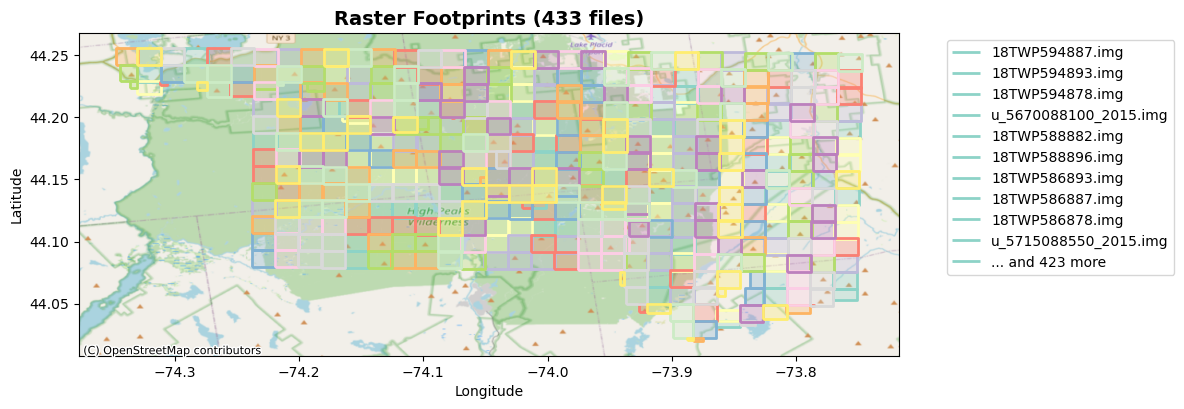

Footprints saved as shapefile
Footprints saved as GeoJSON


In [17]:
# Example usage
if __name__ == "__main__":
    # Replace with your directory path
    tif_directory = "/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/"
    
    # Basic plotting
    gdf = plot_raster_footprints(tif_directory, output_path="raster_footprints.png")
    
    # Enhanced version with statistics
    # gdf = plot_footprints_with_stats(tif_directory)
    
    # If you want to work with the GeoDataFrame further:
    if gdf is not None:
        # Save footprints as shapefile
        gdf.to_file("raster_footprints.shp")
        print("Footprints saved as shapefile")
        
        # Or as GeoJSON
        gdf.to_file("raster_footprints.geojson", driver="GeoJSON")
        print("Footprints saved as GeoJSON")

In [14]:
__name__

'__main__'

In [15]:
?__name__

Type:        str
String form: __main__
Length:      8
Docstring:  
str(object='') -> str
str(bytes_or_buffer[, encoding[, errors]]) -> str

Create a new string object from the given object. If encoding or
errors is specified, then the object must expose a data buffer
that will be decoded using the given encoding and error handler.
Otherwise, returns the result of object.__str__() (if defined)
or repr(object).
encoding defaults to 'utf-8'.
errors defaults to 'strict'.

In [2]:
?wbt.mosaic

Signature: wbt.mosaic(output, inputs=None, method='nn', callback=None)
Docstring:
Mosaics two or more images together.

Keyword arguments:

inputs -- Input raster files.
output -- Output raster file.
method -- Resampling method; options include 'nn' (nearest neighbour), 'bilinear', and 'cc' (cubic convolution).
callback -- Custom function for handling tool text outputs.
File:      /opt/miniconda3/envs/geospatial-processing/lib/python3.13/site-packages/whitebox/whitebox_tools.py
Type:      method

In [39]:
files = glob.glob(os.path.join("/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/", r'*.img'))

In [40]:
#wbt.set_working_dir("/Users/Anthony/Data and Analysis Local/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs")
wbt.mosaic(
    inputs=files, 
    output="/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/test_mosaic.tif",
    method="bilinear"
)

./whitebox_tools --run="Mosaic" --wd="/Users/Anthony/Data and Analysis Local/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs" --inputs='['/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/18TWP594887.img', '/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/18TWP594893.img', '/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/18TWP594878.img', '/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/u_5670088100_2015.img', '/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/18TWP588882.img', '/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/18TWP588896.img', '/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/18TWP586893.img', '/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/18TWP586887.img', '/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/18TWP586878.img', '/Users/Anthony/Data and Analysis Local

0

In [24]:
def mosaic_rasters_whitebox(input_directory, output_mosaic, method='bilinear'):
    """
    Mosaic hundreds of rasters using WhiteBox Tools.
    
    Parameters:
    - input_directory: Path to directory containing raster files
    - output_mosaic: Path for output mosaic file
    - method: Resampling method ('nn', 'bilinear', 'cubic')
    """
    
    # Initialize WhiteBox
    wbt = whitebox.WhiteboxTools()
    wbt.verbose = True
    
    # Find all raster files
    raster_files = []
    for ext in ['*.tif', '*.tiff', '*.img', '*.IMG']:
        raster_files.extend(glob.glob(os.path.join(input_directory, ext)))
    
    print(f"Found {len(raster_files)} raster files")
    
    if len(raster_files) < 2:
        print("Need at least 2 rasters to mosaic")
        return
    
    # Create input list string (semicolon-separated)
    input_list = ";".join(raster_files)
    
    # Run mosaic
    try:
        wbt.mosaic(
            inputs=input_list,
            output=output_mosaic,
            method=method
        )
        print(f"Mosaic completed: {output_mosaic}")
        
    except Exception as e:
        print(f"Error during mosaicking: {e}")

In [30]:
if __name__ == "__main__":
    
    # Basic mosaic
    input_dir = "/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs"
    output_file = "/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/test_mosaic.tif"
    
    mosaic_rasters_whitebox(input_dir, output_file, method='bilinear')

Found 433 raster files
./whitebox_tools --run="Mosaic" --inputs='/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/18TWP594887.img;/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/18TWP594893.img;/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/18TWP594878.img;/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/u_5670088100_2015.img;/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/18TWP588882.img;/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/18TWP588896.img;/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/18TWP586893.img;/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/18TWP586887.img;/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/18TWP586878.img;/Users/Anthony/Data and Analysis Local/NYS_Wetlands_GHG/Data/DEMs/imgs/u_5715088550_2015.img;/Users/Anthony/Data and Analysis Local/NYS_Wetlands_G